<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Departamento de Datos no Estructurados  </h1>


En el Departamento de Datos No Estructurados buscamos personas con excelentes capacidades técnicas a las que les guste explorar los últimos avances en IA para asumir retos de especial dificultad. Aunque la siguiente prueba busca, en primera instancia, corroborar su idoneidad técnica, para nosotros es muy importante que esta destreza venga acompañada de dos elementos adicionales:

1.   Creatividad para encarar desafíos técnicos en procesamiento de datos no estructurados.
2.   Habilidad para comunicar el trabajo hecho y sus resultados a un público general o experto.


---


### **Análisis de Tweets**

Una de las actividades tipicas en el departamento es el analisis, mineria de texto y procesamiento de lenguaje natural para los diferentes procesos operativos o que tienen interacción con el Banco. Para este ejercicio se adjutará un base de datos llamada **davivienda_tweets.csv** o directamente puede descargarla empleando el siguiente comando.

```
!wget "https://raw.githubusercontent.com/yemoncada/davivienda_tweets/main/davivienda_tweets.csv" -P "/content"
```

Este archivo contiene un conjunto de **tweets extraidos de la red social** de Twitter que contienen la palabra **Davivienda** y con el cual quisieramos conocer cual es la interacción que tienen los diferentes usuarios de la red social con el Banco Davivienda. Todo esto a partir de una exploración general de lo que esta en los textos, cabe destacar que este notebook esta diseñado para que realice una exploración guiada y que por medio de esta vaya realizando sus propios descubrimientos e insights sobre la base de datos.

Por último y con la finalidad de obtener un analisis más detallado, realice un modelo no supervisado Latent Dirichlet Allocation (LDA) que permita conocer por topicos, cuales son los temas más hablados en Twitter asociados a la palabra Davivienda.

<p><img alt="Colaboratory logo" src="https://i.ibb.co/3zNV9vX/1-Gp-PEknl-KMQ09-Uk-Et-Y6-MZOw.png" align="left" hspace="10px" vspace="15px"></p>


***Nota***: *Considere que este ejercicio es hipotético y el banco no usará su trabajo más que para evaluar sus habilidades para el cargo*



---



## 1. Librerías y dependencias

Para garantizar el correcto funcionamiento de los desarrollos realizados en el presente Notebook, es requerida la instalación de las siguientes librerías:


In [ ]:
!pip install unidecode


import pandas as pd
import numpy as np
import spacy
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from unidecode import unidecode
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models
import google.auth
from google.colab import auth
import time
from IPython.display import Image, display


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.9 MB/s eta 0:00:00


Adicionalmente, se confirman las dependencias extras que se pueden tener con sus respectivas versiones:

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

##2. Exploración de datos

Para garantizar un cargue de la información rápido y replicable por cualquier usuario, se realiza la creación de un repositorio propio en GitHub donde se carga la información sujeta al análisis, posteriormente se realiza la carga de la misma al Notebook.

In [ ]:
tweets= pd.read_csv("https://raw.githubusercontent.com/Serebas12/Prueba_ADNE_Sebastian_Saavedra/main/Tweets/davivienda_tweets.csv", skip_blank_lines=True)

Una vez cargada la información, se procede a la visualización de una pequeña muestra, así como una revisión de valores faltantes y tipos de variables presentes en el conjunto de datos.

In [ ]:
tweets.head(5)

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1811 non-null   int64  
 1   UserScreenName  1807 non-null   object 
 2   UserName        1811 non-null   object 
 3   Timestamp       1811 non-null   object 
 4   Text            1811 non-null   object 
 5   Embedded_text   1811 non-null   object 
 6   Emojis          295 non-null    object 
 7   Comments        838 non-null    float64
 8   Likes           247 non-null    object 
 9   Retweets        643 non-null    object 
 10  Image link      1811 non-null   object 
 11  Tweet URL       1811 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 169.9+ KB


In [ ]:
tweets.dtypes

Unnamed: 0          int64
UserScreenName     object
UserName           object
Timestamp          object
Text               object
Embedded_text      object
Emojis             object
Comments          float64
Likes              object
Retweets           object
Image link         object
Tweet URL          object
dtype: object

En primer lugar, se realizará una eliminación de variables que no son sujetas al analisis o cuentan con un gran porcentaje de valores faltantes. Al analizar la data se procede a la eliminación de las siguientes variables:  

- **Emojis**: Variable eliminada por completitud.
- **Image link:** Variable eliminada porque las imágenes referencias en los Tweet no será sujetas de análisis
- **Tweet URL:** Variable eliminada porque no será sujeta a análisis
- **Text:** Variable eliminada porque su información se encuentra contenida en otras columnas.
- **Unnamed: 0**: Variable eliminada dado que es un indicador.
- **UserScreenName**: Variable eliminada dado que para el identificador del usuario se utilizará la variable *UserName*

In [ ]:
tweets=tweets.drop(columns=['Emojis','Image link','Tweet URL','Text','Unnamed: 0','UserScreenName'])
tweets.head()

,UserName,Timestamp,Embedded_text,Comments,Likes,Retweets
0,@ALangebaek,2021-12-01T20:43:12.000Z,La confianza se afectó. El indicador de confia...,1.0,7,19
1,@plaza_futura,2021-12-01T21:18:10.000Z,Buscamos la accesibilidad y mejor atención en ...,NaN,NaN,NaN
2,@JulianM998,2021-12-01T22:49:11.000Z,Señores \n@Davivienda\n no he podido ingresar ...,1.0,NaN,1
3,@fergomezr28,2021-12-01T12:29:07.000Z,Llevo toda una semana sufriendo intento de hur...,2.0,1,2
4,@MirandaSuspLo,2021-12-01T20:52:36.000Z,Hemos retrocedido tanto en este país con este ...,3.0,NaN,8


Con el fin de tener un mayor contexto de los Tweet realizados, se procede a validar el rango de fechas en los cuales estos fueron publicados, teniendo en cuenta que hay fechas en las que la operación de Davivienda es más crítica por la demanda de los usuarios, para lo cual inicialmente se hace una transformación del tipo de la variable *Timestamp*

In [ ]:
tweets['Timestamp'] = pd.to_datetime(tweets['Timestamp'] )
tweets.head()

,UserName,Timestamp,Embedded_text,Comments,Likes,Retweets
0,@ALangebaek,2021-12-01 20:43:12+00:00,La confianza se afectó. El indicador de confia...,1.0,7,19
1,@plaza_futura,2021-12-01 21:18:10+00:00,Buscamos la accesibilidad y mejor atención en ...,NaN,NaN,NaN
2,@JulianM998,2021-12-01 22:49:11+00:00,Señores \n@Davivienda\n no he podido ingresar ...,1.0,NaN,1
3,@fergomezr28,2021-12-01 12:29:07+00:00,Llevo toda una semana sufriendo intento de hur...,2.0,1,2
4,@MirandaSuspLo,2021-12-01 20:52:36+00:00,Hemos retrocedido tanto en este país con este ...,3.0,NaN,8


Finalmente, se observa que los tweets se encuentran entre el 1 de Diciembre de 2021 y el 22 de Diciembre del 2021, lo cual es valioso de conocer, dado que la cantidad de transacciones realizadas por los clientes en este periodo de tiempo es mayor a comparación del resto del año debido a la temporada navideña

In [ ]:
print( f"tweet más antiguo {min(tweets['Timestamp'])}"  )
print( f"tweet más reciente {max(tweets['Timestamp'])}"  )

tweet más antiguo 2021-12-01 00:01:49+00:00
tweet más reciente 2021-12-22 23:53:50+00:00


## 3. Prepocesamiento de Texto

El objetivo del presente análisis es poder analizar a detalle el contenido de cada uno de los tweets, por lo cual nos centraremos en la variable *Embedded_text*, ya que esta contiene dicha información. Sin embargo, para poder analizar la información primero la debemos estandarizar, ya que muchos clientes pueden referirse al mismo tema pero escribiendo palabras con tildes o haciendo uso de mayúsculas u otros caracteres especiales, lo cual podría afectar el posterior análisis. Por lo tanto, se realizar una normalización de información con la librería Spacy, en donde primero se carga un pipeline entrenado para información en español.

In [ ]:
spacy.cli.download("es_core_news_sm")
nlp = spacy.load("es_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Las técnicas de preprocesamiento que serán empleadas en el conjunto de datos para lograr la estandarización de la información son:

- **Normalización:** Se hace uso de la función *unidecode* para eliminar acentos de las palabras incluidas en los tweets, adicionalmente se deja todo el texto en minúsculas con la función *lower*
- **Limpieza con expresiones regulares:** Mediante expresiones regulares únicamente nos quedamos con caracteres alfanuméricos, adicionalmente se realiza eliminación de espacios duplicados.
- **Filtro de tokens:** Se realiza eliminación de tokens con una longitud inferior a 2 caracteres.

Finalmente para cada resultado obtenido se realiza una concatenación para tener un conjunto de tokens por cada Tweet realizado.

In [ ]:
def preprocess(text, nlp):

    normalizado= unidecode(text).lower()  # Normalizado y minuscula

    pat = re.compile(r"[^\w ]") # Expresión para borrar caracteres diferentes a letras
    spaces = re.compile(r"\s{2,}") #expresión que borra espacios

    limpieza=re.sub(pat, " ", normalizado)
    limpieza=re.sub(spaces, " ", limpieza)

    tokens= nlp(limpieza) # convierte en formato spicy
    filtrado=filter(lambda token: ( len(token) > 1 ), tokens)
    preprocess_text = " ".join(token.text for token in filtrado) ## convierte a string y concatena

    return preprocess_text

Como se mencionó anteriormente, nuestro objetivo será el análisis de la variable *Embedded_text*, por lo cual se procede a la ejecución de la función *preprocess* sobre dicha variable

In [ ]:
Corpus_tweets = tweets.Embedded_text
docs = [nlp(str(doc)) for doc in Corpus_tweets ]
docs_2 = [preprocess(str(doc),nlp) for doc in docs ]

Finalmente, se muestra un ejemplo de la información original y la información preprocesada para los primeros 5 Tweets del conjunto de datos.

In [ ]:
print("Documentos originales \n \n")
display(docs[0:5])
print("\n \n  Documentos preprocesados \n \n")
display(docs_2[0:5])

Documentos originales 
 



[La confianza se afectó. El indicador de confianza Davivienda tuvo una  leve caída en noviembre, rompiendo una tendencia de cinco meses de mejoras. El indicador se deterioró, especialmente en la última semana del mes, asociado al aumento en la tasa de cambio.
 1
 7
 19,
 Buscamos la accesibilidad y mejor atención en tus trámites bancarios, es por ello que encuentras en nuestra plaza los siguientes bancos para tu preferencia.
  Banco Cuscatlán
  Banco Fedecrédito
  Davivienda
  Bancoagrícola
  Banco Promerica,
 Señores 
 @Davivienda
  no he podido ingresar a mi app davivienda, ingreso la cédula y me dice verifique los datos, llevo así varios días.
 1
 1,
 Llevo toda una semana sufriendo intento de hurto por medios electrónicos a mi cuenta de ahorros 
 @Davivienda
 , sin que se puedan realizar porque no tengo plata. No felices, lo hicieron con la TC y con esta sí pudieron ya que tenía cupo libre. ¿Qué está pasando 
 @Davivienda
 ?
 2
 1
 2,
 Hemos retrocedido tanto en este país con este 


 
  Documentos preprocesados 
 



['la confianza se afecto el indicador de confianza davivienda tuvo una leve caida en noviembre rompiendo una tendencia de cinco meses de mejoras el indicador se deterioro especialmente en la ultima semana del mes asociado al aumento en la tasa de cambio 19',
 'buscamos la accesibilidad mejor atencion en tus tramites bancarios es por ello que encuentras en nuestra plaza los siguientes bancos para tu preferencia banco cuscatlan banco fedecredito davivienda bancoagricola banco promerica',
 'senores davivienda no he podido ingresar mi app davivienda ingreso la cedula me dice verifique los datos llevo asi varios dias',
 'llevo toda una semana sufriendo intento de hurto por medios electronicos mi cuenta de ahorros davivienda sin que se puedan realizar porque no tengo plata no felices lo hicieron con la tc con esta si pudieron ya que tenia cupo libre que esta pasando davivienda',
 'hemos retrocedido tanto en este pais con este gobierno que hasta los malparidos cajeros de davivienda dizque sol

## 4. Modelo de sentimientos

Teniendo en cuenta que el objetivo es conocer la intención de cada Tweet, se propone el uso de un modelo de sentimientos, para lo cual se pueden contemplar múltiples opciones de desarrollo, como creación de modelo, Transfer Learning, Fine Tunning o uso de un LLM de industria.

Para el alcance de este proyecto se decidió trabajar con modelos LLM de industria, esto considerando que son modelos robustos que permiten la extracción de sentimientos e ideas principales de los Tweets, contemplando que los usuarios pueden usar "jerga regional", lo cual podría ser un comportamiento no capturado por el resto de modelos. Adicionalmente, no se cuenta con información suficiente para el ajuste adecuado de las otras alternativas, dado que solo tenemos 1.811 Tweets.

Una vez aclarado que se utilizará un modelo de LLM de industria, se debe definir cual de ellos será. Para el proyecto se propone el uso de *gemini-1.5-flash-001* el cual es uno de los modelos de lenguaje natural más recientes de Google y comparados con su competencia presenta un bajo costo. El uso de este modelo se hará mediante las APIS de Google Cloud Platform, por lo cual procedemos a realizar la respectiva autenticación:


In [ ]:
# Autenticar con Google
auth.authenticate_user()

# Obtener las credenciales y el proyecto predeterminado
credentials, project = google.auth.default()

Adicionalmente, se crea la función *generate*, la cual permite realizar la conexión directamente al modelo de Gemini. Vale la pena aclarar que las configuraciones utilizadas para el llamado del modelo son las de defecto recomendadas por Google (*temperature* y *top_p*), únicamente se realizó cambio en el número de tokens máximo esperado y los *safety_settings*, teniendo en cuenta que los comentarios vienen de *Tweeter* y aquí no se presenta una restricción en cuando al contenido publicado.

In [ ]:
def generate(prompt):
  vertexai.init(project="hybrid-robot-425722-j4", location="us-central1")
  model = GenerativeModel(
    "gemini-1.5-flash-001",
  )
  responses = model.generate_content(
      [prompt],
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )

  respuesta=''

  for response in responses:
    respuesta=respuesta + response.text

  return respuesta

generation_config = {
    "max_output_tokens": 1000,
    "temperature": 1,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

Para el llamado del API de Gemini es necesario la construcción de un prompt el cual contemple las instrucciones del proceso que debe realizar el modelo y el contenido de los Tweets, para lo cual se crea la variable *Alcance*, la cual contiene dichas instrucciones, en donde se solicita al modelo clasificar el Tweet en tres categorías *Positivo*, *Negativo* y *Neutro* y posteriormente dar una breve explicación del porque dicha clasificación.

In [ ]:
Alcance="Eres un clasificador de sentimientos del Banco Davivienda, debes clasificar comentarios de los usuarios en las categorías Positivo, Negativo o Neutro, adicionalmente debes dar un pequeño resumen del porque dicha clasificación en menos de 10 palabras. La respuesta debe ser un string sin saltos de linea donde primero se de la clasificación, luego un punto y la respectiva justificación."


Se procede el llamado del api para cada uno de los Tweet, sin embargo, se debe contemplar las cuotas de concurrencia del API de Gemini, para los proyectos por defecto es de 5 llamados por minuto. Para poder abordar este ejercicio se escaló un ticket a Google lo cual permitió la ampliación de dicha cuota, adicionalmente, se tienen que contemplar los casos en los cuales el API no pueda brindar una respuesta porque los Tweets contienen contenido peligroso, contenido sexual explicito o contenido de acoso.

In [ ]:
resultado_gemini=[]
for tweet in docs_2:
    try:
        resultado=  generate(Alcance + tweet)

    except:
        resultado= "No aplica. Contenido explicito. Eliminar"

    resultado_gemini.append(resultado)


Con el fin de estructurar las respuestas de Gemini, se crea el DataFrame *df_clasificado*, en donde se realizará una marca para determinar el sentimiento, adicionalmente, se guarda una copia local teniendo en cuenta que el llamado al API tiene un costo.

In [ ]:
#df_clasificado = pd.DataFrame(resultado_gemini, columns=['original'])
df_clasificado=pd.read_csv("df_clasificado")
df_clasificado["Sentimiento"]='No aplica'

df_clasificado.loc[df_clasificado['original'].str.contains('Negativo', case=False, na=False), 'Sentimiento'] = 'Negativo'
df_clasificado.loc[df_clasificado['original'].str.contains('Positivo', case=False, na=False), 'Sentimiento'] = 'Positivo'
df_clasificado.loc[df_clasificado['original'].str.contains('Neutro', case=False, na=False), 'Sentimiento'] = 'Neutro'

df_clasificado.head()

#df_clasificado.to_csv("df_clasificado", index=False)

,original,Sentimiento
0,Negativo. Confianza afectada por caída del ind...,Negativo
1,Neutro. Menciona opciones de bancos. \n,Neutro
2,Negativo. Problema de acceso a la app. \n,Negativo
3,Negativo. Pérdida de tiempo y dinero. \n,Negativo
4,Negativo. Mal servicio al cliente. \n,Negativo


Se procede al análisis de la distribución de los sentimientos clasificados, encontrando que su gran mayoría (Aproximadamente 70%) corresponde al sentimiento negativo, lo cual inicialmente puede explicarse a que la mayoría de los tweets publicados de este tipo de red social tiene como finalidad reportar un fallo o hacer notar una inconformidad referente a un servicio.


Al analizar las categorías creadas, se observa que hay 18 registros con Sentimiento *No aplica*, al ver el detalle, se debe a que no se tiene información suficiente para realizar el análisis o que los Tweets contienen restricciones referentes a contenido peligroso, contenido sexual explicito o contenido de acoso, por lo cual no es posible realizar un análisis con el API de Gemini. Se procede a la eliminación de estos registros dentro del análisis.

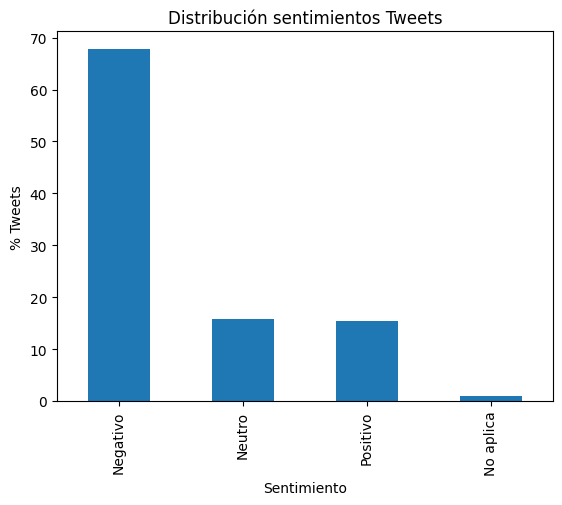

In [ ]:
conteos= df_clasificado["Sentimiento"].value_counts()
porcentajes= conteos / conteos.sum() * 100

porcentajes.plot(kind='bar')
plt.xlabel('Sentimiento')
plt.ylabel('% Tweets')
plt.title('Distribución sentimientos Tweets')

plt.show()

In [ ]:
df_clasificado[df_clasificado["Sentimiento"]=='No aplica']

,original,Sentimiento
115,No aplica. Contenido explicito. Eliminar,No aplica
179,¡Entendido! Dime el comentario del usuario y t...,No aplica
367,No aplica. Contenido explicito. Eliminar,No aplica
396,"Por favor, proporciona el comentario del usuar...",No aplica
483,No aplica. Contenido explicito. Eliminar,No aplica
591,No aplica. Contenido explicito. Eliminar,No aplica
602,"Lo siento, no puedo ayudarte con eso. No teng...",No aplica
664,"Ok, dime el comentario del usuario y te diré l...",No aplica
722,"Lo siento, no puedo proporcionar información q...",No aplica
743,No aplica. Contenido explicito. Eliminar,No aplica


In [ ]:
df_clasificado_filtrado = df_clasificado[df_clasificado["Sentimiento"]!='No aplica']
df_clasificado_filtrado.head()

,original,Sentimiento
0,Negativo. Confianza afectada por caída del ind...,Negativo
1,Neutro. Menciona opciones de bancos. \n,Neutro
2,Negativo. Problema de acceso a la app. \n,Negativo
3,Negativo. Pérdida de tiempo y dinero. \n,Negativo
4,Negativo. Mal servicio al cliente. \n,Negativo


Finalmente, para poder detallar la razón de cada una de estás clasificaciones se realizará un análisis sobre la variable "original", sin embargo, esta respuesta debe ser estandarizada como se realizó anteriormente, Adicionalmente, se realizará la eliminación de Stop Words dentro del texto, así como de las palabras *davivienda*,*negativo*, *positivo* y *neutro*, ya que es de esperar que la mayoría de Tweets las contengan.

In [ ]:
def preprocess_2(text, nlp):

    normalizado= unidecode(text).lower()  # Normalizado y minuscula

    pat = re.compile(r"[^\w ]") # Expresión para borrar caracteres diferentes a letras
    spaces = re.compile(r"\s{2,}") # #xpresión que borra espacios
    banco = re.compile(r'\b(davivienda)\b') #Expresión para borrar Davivienda
    negativo= re.compile(r'\b(negativo)\b')
    neutro= re.compile(r'\b(neutro)\b')
    positivo= re.compile(r'\b(positivo)\b')

    limpieza=re.sub(pat, " ", normalizado)
    limpieza=re.sub(spaces, " ", limpieza)
    limpieza=re.sub(banco, " ", limpieza)
    limpieza=re.sub(negativo, " ", limpieza)
    limpieza=re.sub(neutro, " ", limpieza)
    limpieza=re.sub(positivo, " ", limpieza)

    tokens= nlp(limpieza) # convierte en formato spicy
    filtrado=filter(lambda token: ( len(token) > 1 and not token.is_stop  ), tokens)  ## Se eliminan stop words
    preprocess_text = " ".join(token.text for token in filtrado) ## convierte a string y concatena

    return preprocess_text

Corpus_sentimientos = df_clasificado_filtrado['original']
docs_sent = [nlp(str(doc)) for doc in Corpus_sentimientos ]
docs_sent2 = [preprocess_2(str(doc),nlp) for doc in docs_sent ]

df_clasificado_filtrado['Justificación_procesada']=docs_sent2
df_clasificado_filtrado.head()

<ipython-input-11-573d0def3622>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clasificado_filtrado['Justificación_procesada']=docs_sent2


,original,Sentimiento,Justificación_procesada
0,Negativo. Confianza afectada por caída del ind...,Negativo,confianza afectada caida indicador
1,Neutro. Menciona opciones de bancos. \n,Neutro,menciona opciones bancos
2,Negativo. Problema de acceso a la app. \n,Negativo,problema acceso app
3,Negativo. Pérdida de tiempo y dinero. \n,Negativo,perdida tiempo dinero
4,Negativo. Mal servicio al cliente. \n,Negativo,servicio cliente


Una vez estandarizada la información, se procede a realizar una nube de palabras con todos los Tweets segregadas por cada sentimiento, con el fin de determinar las principales características de cada uno de los grupos.

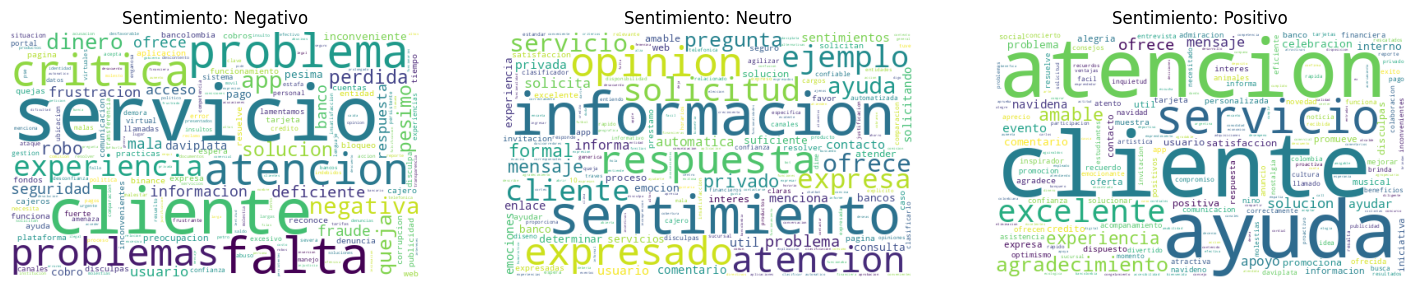

In [ ]:
Sentimientos=['Negativo','Neutro','Positivo']

fig, axes = plt.subplots(1, 3, figsize=(18, 14) )
cont=0

for valor in Sentimientos:
    ax = axes[cont]
    ax.set_title(f"Sentimiento: {valor}")
    cont=cont + 1
    vect = CountVectorizer(max_features=3000).fit(df_clasificado_filtrado[df_clasificado_filtrado['Sentimiento'] == valor]['Justificación_procesada']) # Se toman unicamente las 3.000 palabras más comunes
    X = vect.transform(df_clasificado_filtrado[df_clasificado_filtrado['Sentimiento'] == valor]['Justificación_procesada']).toarray()

    counts = np.array(X.sum(axis=0)).flatten()
    vocab = vect.get_feature_names_out()
    counts_dict = {word: count for word, count in zip(vocab, counts)}
    wc = (
            WordCloud( width=500, height=300,background_color='#FFFFFF')
            .generate_from_frequencies(counts_dict)
            )
    display(wc)

    ax.imshow(wc)
    ax.axis("off")


Al analizar las principales palabras, vemos que no es posible dar un conclusión de cada una de las categorías, teniendo en cuenta que palabras como *servicio* o *cliente* salen en las categorías negativa y positiva, y no nos da un mayor detalle, razón por la cual se procede a realizar una nube de palabras con bigramas.

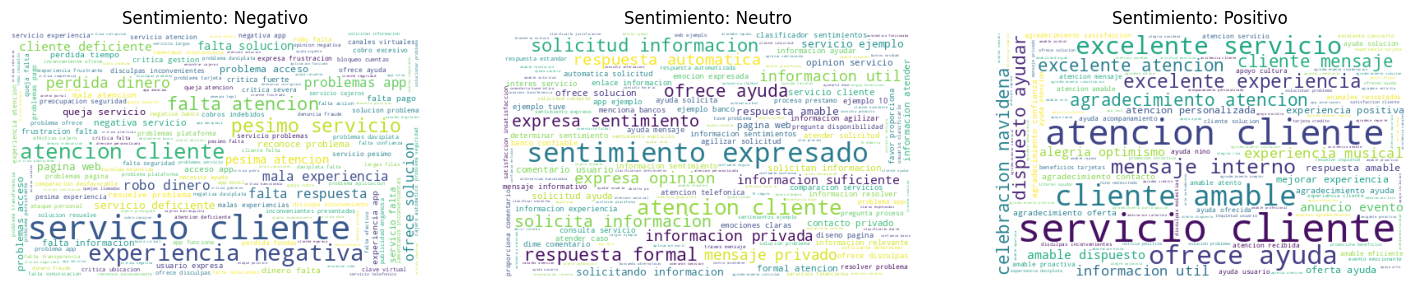

In [ ]:
Sentimientos=['Negativo','Neutro','Positivo']

fig, axes = plt.subplots(1, 3, figsize=(18, 14) )
cont=0

for valor in Sentimientos:
    ax = axes[cont]
    ax.set_title(f"Sentimiento: {valor}")
    cont=cont + 1
    vect = CountVectorizer(analyzer="word", ngram_range=(2, 2),max_features=3000).fit(df_clasificado_filtrado[df_clasificado_filtrado['Sentimiento'] == valor]['Justificación_procesada']) # Se toman unicamente las 3.000 palabras más comunes
    X = vect.transform(df_clasificado_filtrado[df_clasificado_filtrado['Sentimiento'] == valor]['Justificación_procesada']).toarray()

    counts = np.array(X.sum(axis=0)).flatten()
    vocab = vect.get_feature_names_out()
    counts_dict = {word: count for word, count in zip(vocab, counts)}
    wc = (
            WordCloud( width=500, height=300,background_color='#FFFFFF')
            .generate_from_frequencies(counts_dict)
            )
    display(wc)

    ax.imshow(wc)
    ax.axis("off")

Al analizar el bigrama, podemos realizar una caracterización más detallada de cada categoría, principalmente nos centraremos en las categorías Positiva y Negativa, dado que nos muestran la percepción de puntos débiles y fuertes del Banco por parte de los usuarios:

- **Negativo**: Los comentarios más recurrentes de los usuarios están relacionamos a malas experiencia, en torno a la atención y servicio, así como perdida de dinero y problemas de la app.

- **Positivo**: Los comentarios son referentes a usuarios que tuvieron una experiencia favorable, ya que se les brindo una buena atención en los servicios solicitados.


##5. Implementación

Referente a la implementación del modelo depende principalmente del presupuesto que este tenga asociado y los requerimientos de tiempo de respuesta que este presenta, con el fin de determinar si la implementación será en una arquitectura Batch o Real time.



##5.1 Implementación Batch

Teniendo en cuenta que Gemini es un servicio de Google Cloud Platforma, se propone la implementación de la solución completa en la misma nube, recomendado la siguiente aquitectura:

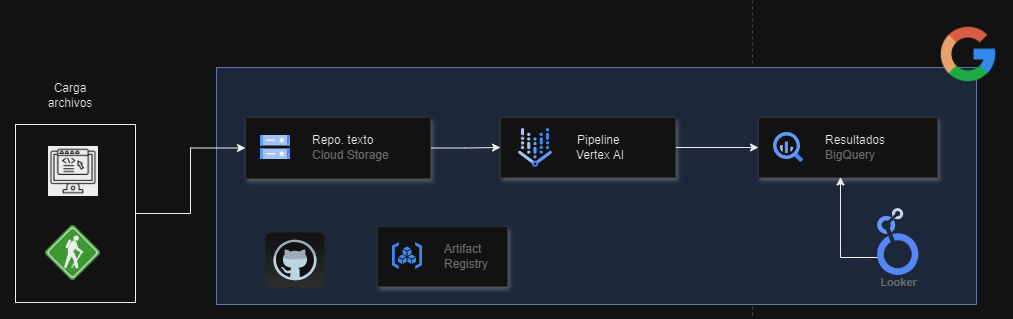

In [ ]:
display(Image("Batch.png", height=400))

- **Cloud Storage**: Repositorio en donde se deben alojar los Tweets sujetos al análisis.
- **Vertex AI**: Servicio donde se automatizará la ejecución del código desarrollado y encargado de escribir información en BigQuery. Se debe calendarizar el proceso creado y se debe considerar los límites de concurrencia del servicio de Gemini tal como se hizo en el presente Notebook.
- **BigQuery**: Repositorio en donde se dejará la información estructurada final
- **Looker**: Servicio que permite la visualización de los resultados de una forma interactiva.
- **GitHub**: Repositorio de código donde también se ejecutarán pruebas unitarias y de vulnerabilidad del código desarrollado.
- **Artifact Registry**: Servicio donde se diponibilizará la imagen creada con el código alojado en GitHub, y será disponibilizada en la instancia de ejecución.
- La carga de los documentos dependerá de la naturaleza del caso de uso a implementar, si se requiere únicamente la disponibilización del modelo para su uso, se recomiendo el uso de un front, por otro lado, si lo que se requiere es un proceso automático masivo, se recomiendan herramientas tipo go anywhere para el cargue de la información.


Es importante recalcar la limitación que se tiene con el número de llamados al API de Gemini, dado que para el desarrollo de este proceso se requirio la modificación de la cuota. Si se tiene una volumetría diaria mayor, se recomienda la ampliación de la cuota, o de ser posible, el uso del api de diferentes proyectos de Google.


##5.2 Implementación Real time


Referente a la implementación del proceso en Real time se propone el uso de la siguiente arquitectura.

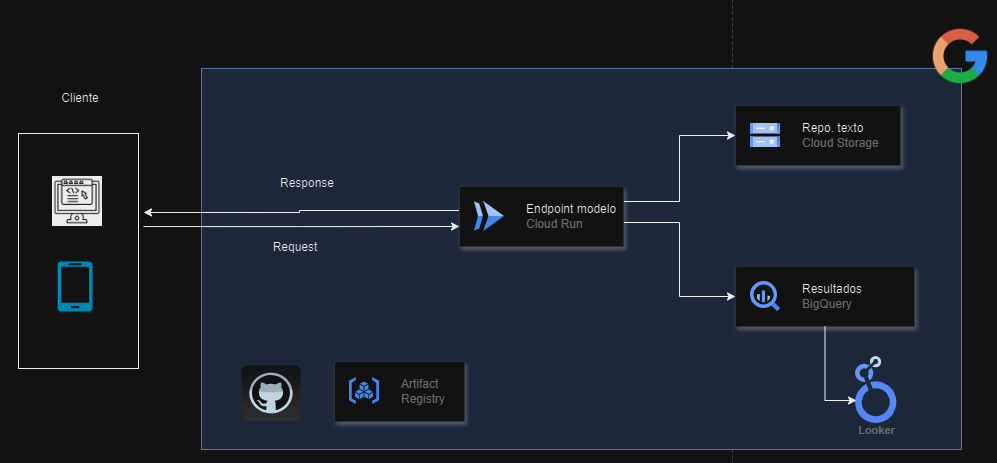

In [ ]:
display(Image("Real Time.png", height=500))

- **Cloud Storage**: Repositorio en donde se deben alojar los Tweets sujetos al análisis.
- **Cloud RUN**: Servicio que contendrá toda la lógica desarrollada para el llamado del api y guardado de información. Tener presente la [cuota limitante de Gemini](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas?hl=es-419), especialmente para este caso de real time. La cuota puede ser modificada mediante la solicitud y justificación a Google.  
- **BigQuery**: Repositorio en donde se dejará la información estructurada final
- **Looker**: Servicio que permite la visualización de los resultados de una forma interactiva.
- **GitHub**: Repositorio de código donde también se ejecutarán pruebas unitarias y de vulnerabilidad del código desarrollado.
- **Artifact Registry**: Servicio donde se diponibilizará la imagen creada con el código alojado en GitHub, y será disponibilizada en la instancia de ejecución.
- Al disponibilizar el desarrollo como un api, se garantiza que pueda ser llamado por cualquier aplicativo, incluyendo apps de celulares o un front de atención.

Adicionalmente, para la exposición del API se deben considerar los lineamientos dados por el equipo de seguridad, con el fin de determinar el camino más adecuado y seguro de implementación, en donde se considerará quien será el cliente final que consumirá dicha API.


## 6. Costos

Para el desarrollo de la presente prueba, se utilizó una maquina base de Google Colab la cual no tiene costo, adicionalmente, se utilizó el API de Gemini pro, la cual si tiene un costo asociado para cada llamado (para más detalle ver [documentación](https://cloud.google.com/vertex-ai/generative-ai/pricing?hl=es-419)), sin embargo, al ser el primer consumo realizado en un proyecto propio, estos costos entran dentro de la capa gratuita ofrecida por Google Cloud Platform.


##7. Conclusiones

Con el objetivo de determinar la intención de 1.811 Tweets que contienen la palabra Davivienda, se implementó un proceso que permite la estandarización de información mediante librerías gratuitas de Python (spicy, Unidecode) para posteriormente ser analizadas por el LLM de Google, Gemini, y fijar una intención Neutra, Negativa o Positiva con su respectivo resumen

El conjunto se caracteriza en su gran mayoría por tener reseñas negativas, ya que aproximadamente el 70% de los Tweets corresponden a la categoría Negativa, en donde se mencionan principalmente problemas referentes al servicio, problemas de perdida de dinero e incluso problemas referentes a la aplicación del banco. Sin embargo, por el lado de los comentarios positivos también se hace mención a servicio, pero esta vez, agradeciendo la atención brindada.

El desarrollo realizado en el presente notebook puede ser escalable y automatizado en un proceso Batch o Real time, lo cual permitirá a la organización conocer la percepción que los clientes tienen de la misma, con el fin de poder abordar temas puntales referentes a las problemáticas más comunes, y así aumentar la percepción positiva del Banco y sus servicios, buscando siempre una mejora continua en pro de la experiencia del cliente.  
